### Reflection Agent (Understanding way)

In [1]:
from typing import TypedDict, Annotated
from operator import add
from langgraph.graph import StateGraph, END
from langchain_ollama import ChatOllama
from langchain_core.prompts import ChatPromptTemplate

In [2]:
# state
class ReflectionState(TypedDict):
    task: str
    solution: str
    critique: str
    revision: str
    iteration: Annotated[int, add]
    max_iterations: int

In [3]:
llm = ChatOllama(model="llama3.2", temperature=0.7)

In [4]:
generate_prompt = ChatPromptTemplate.from_messages([
    ("human", """
Task: {task}
     
     Previous critique (if any): {critique}

     Generate a solution: If there was a critique, improve based on it.

     Solution: 
""")
])

In [5]:
critique_prompt = ChatPromptTemplate.from_messages([
    ("human", """
    Current solution: 
    {solution}
    
    Critique this solution. What could be improved? Be specific and constructive.
    Critique:
""")
])

In [6]:
generate_chain = generate_prompt | llm
critique_chain = critique_prompt | llm

In [7]:
def generate(state: ReflectionState):
    """Generate or revise solution"""
    response = generate_chain.invoke({
        "task": state["task"],
        "critique": state.get("critique", "None yet")
    })

    return {
        "solution": response.content,
        "iteration": 1
    }

In [8]:
def reflect(state: ReflectionState):
    """Critique the solution"""
    response = critique_chain.invoke({
        "task": state["task"],
        "solution": state["solution"]
    })

    return {
        "critique": response.content
    }

In [9]:
def should_continue(state: ReflectionState) -> str:
    if state["iteration"] >= state["max_iterations"]:
        return "end"
    
    if state.get("critique"):
        critique_lower = state["critique"].lower()
        if "good" in critique_lower or "excellent" in critique_lower:
            return "end"
    return "revise"

In [10]:
workflow = StateGraph(ReflectionState)
workflow.add_node("generate", generate)
workflow.add_node("reflect", reflect)

workflow.set_entry_point("generate")
workflow.add_edge("generate", "reflect")
workflow.add_conditional_edges(
    "reflect",
    should_continue,
    {
        "revise": "generate",
        "end": END
    }
)

app = workflow.compile()

In [11]:
from IPython.display import Image, display

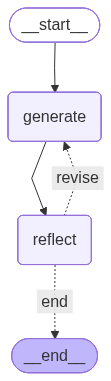

In [12]:
display(Image(app.get_graph().draw_mermaid_png()))

In [17]:
result = app.invoke({
    "task": "Write a haiku about programming",
    "solution": "",
    "critique": "",
    "revision": "",
    "iteration": 0,
    "max_iterations": 5
})

In [18]:
print(f"Final solution:\n{result['solution']}")

Final solution:
Circuitry hums to life
Glowing screens in midnight lab
Error's bitter taste


In [19]:
result["critique"]

'Here\'s a critique of the provided solution:\n\n**Strengths:**\n\n* The use of sensory details like "Circuitry hums to life" effectively creates a vivid image of a technological environment.\n* The phrase "Glowing screens in midnight lab" effectively conveys a sense of isolation and confinement, which could be fitting for an error message.\n\n**Weaknesses and suggestions:**\n\n* The language is quite generic and could apply to many different contexts. Consider adding more specific details or metaphors to make the solution more unique.\n* The phrase "Error\'s bitter taste" feels like a cliché. While it conveys the idea that there\'s an error, it doesn\'t add much depth or insight into what that error might be.\n* The tone of the solution could benefit from being more concise and direct. Some lines feel a bit too poetic or flowery, which may not align with the goal of presenting a clear error message.\n\n**Specific suggestions:**\n\n* Consider adding more context about what kind of erro

In [20]:
from typing import TypedDict, Annotated, Literal, Sequence
from operator import add
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_ollama import ChatOllama
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, BaseMessage
import logging

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Production state with proper message handling
class ProductionReflectionState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add]
    current_solution: str
    reflection_count: Annotated[int, add]
    max_reflections: int
    quality_threshold: float
    current_quality: float
    status: Literal["generating", "reflecting", "complete", "error"]

# Initialize LLM
llm = ChatOllama(model="llama3.2", temperature=0.7)

# System prompts as constants (best practice)
GENERATOR_SYSTEM = """You are an expert problem solver. Generate high-quality solutions.
If you receive feedback, incorporate it to improve your solution."""

REFLECTOR_SYSTEM = """You are a critical reviewer. Analyze solutions objectively.

Provide:
1. Quality score (0-10)
2. Specific strengths
3. Specific weaknesses  
4. Actionable improvement suggestions

Format:
SCORE: X/10
STRENGTHS: ...
WEAKNESSES: ...
SUGGESTIONS: ..."""

# Prompts with proper templates
generate_prompt = ChatPromptTemplate.from_messages([
    ("system", GENERATOR_SYSTEM),
    ("placeholder", "{messages}"),
])

reflect_prompt = ChatPromptTemplate.from_messages([
    ("system", REFLECTOR_SYSTEM),
    ("human", """Original task: {task}

Current solution:
{solution}

Provide your analysis:""")
])

# Chains
generate_chain = generate_prompt | llm
reflect_chain = reflect_prompt | llm

# Nodes with error handling
def generate_solution(state: ProductionReflectionState) -> dict:
    """Generate or improve solution based on messages"""
    try:
        logger.info(f"Generating solution (attempt {state['reflection_count'] + 1})")
        
        response = generate_chain.invoke({"messages": state["messages"]})
        
        return {
            "messages": [AIMessage(content=response.content)],
            "current_solution": response.content,
            "status": "reflecting",
            "reflection_count": 1
        }
    
    except Exception as e:
        logger.error(f"Generation error: {e}")
        return {
            "status": "error",
            "messages": [AIMessage(content=f"Error: {str(e)}")]
        }

def reflect_on_solution(state: ProductionReflectionState) -> dict:
    """Provide critique and quality assessment"""
    try:
        logger.info("Reflecting on solution")
        
        # Extract original task from first human message
        original_task = ""
        for msg in state["messages"]:
            if isinstance(msg, HumanMessage):
                original_task = msg.content
                break
        
        response = reflect_chain.invoke({
            "task": original_task,
            "solution": state["current_solution"]
        })
        
        reflection = response.content
        
        # Parse quality score
        quality = 5.0  # Default
        if "SCORE:" in reflection:
            try:
                score_line = [line for line in reflection.split('\n') if 'SCORE:' in line][0]
                score_str = score_line.split('SCORE:')[1].split('/')[0].strip()
                quality = float(score_str)
            except:
                logger.warning("Could not parse quality score")
        
        return {
            "messages": [SystemMessage(content=f"Reflection: {reflection}")],
            "current_quality": quality,
            "status": "generating"  # Will decide next in router
        }
    
    except Exception as e:
        logger.error(f"Reflection error: {e}")
        return {
            "status": "error",
            "messages": [SystemMessage(content=f"Reflection error: {str(e)}")]
        }

# Router with quality threshold
def should_continue_reflecting(state: ProductionReflectionState) -> str:
    """Decide whether to continue reflection loop"""
    
    # Error state
    if state["status"] == "error":
        logger.error("Stopping due to error")
        return "end"
    
    # Max iterations reached
    if state["reflection_count"] >= state["max_reflections"]:
        logger.info(f"Max reflections ({state['max_reflections']}) reached")
        return "end"
    
    # Quality threshold met
    if state["current_quality"] >= state["quality_threshold"]:
        logger.info(f"Quality threshold met: {state['current_quality']:.1f}/10")
        return "end"
    
    # Continue improving
    logger.info(f"Quality {state['current_quality']:.1f}/10 below threshold {state['quality_threshold']}, continuing")
    return "generate"

# Build production graph
workflow = StateGraph(ProductionReflectionState)

workflow.add_node("generate", generate_solution)
workflow.add_node("reflect", reflect_on_solution)

workflow.set_entry_point("generate")
workflow.add_edge("generate", "reflect")
workflow.add_conditional_edges(
    "reflect",
    should_continue_reflecting,
    {
        "generate": "generate",
        "end": END
    }
)

# Compile with checkpointing for production
checkpointer = MemorySaver()
production_reflection_agent = workflow.compile(checkpointer=checkpointer)

# Production API
def reflect_and_improve(
    task: str,
    max_reflections: int = 3,
    quality_threshold: float = 8.0,
    session_id: str = "default"
) -> dict:
    """
    Production-ready reflection agent.
    
    Args:
        task: The problem to solve
        max_reflections: Maximum number of improvement iterations
        quality_threshold: Minimum quality score to accept (0-10)
        session_id: Session identifier for checkpointing
    
    Returns:
        dict with solution, quality, and metadata
    """
    
    config = {
        "configurable": {
            "thread_id": f"reflection-{session_id}"
        }
    }
    
    initial_state = {
        "messages": [HumanMessage(content=task)],
        "current_solution": "",
        "reflection_count": 0,
        "max_reflections": max_reflections,
        "quality_threshold": quality_threshold,
        "current_quality": 0.0,
        "status": "generating"
    }
    
    try:
        result = production_reflection_agent.invoke(initial_state, config=config)
        
        # Extract reflections
        reflections = [
            msg.content for msg in result["messages"] 
            if isinstance(msg, SystemMessage) and "Reflection:" in msg.content
        ]
        
        return {
            "success": True,
            "solution": result["current_solution"],
            "quality_score": result["current_quality"],
            "iterations": result["reflection_count"],
            "reflections": reflections,
            "status": result["status"]
        }
    
    except Exception as e:
        logger.error(f"Reflection agent failed: {e}")
        return {
            "success": False,
            "error": str(e)
        }

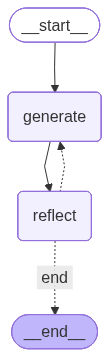

In [21]:
display(Image(production_reflection_agent.get_graph().draw_mermaid_png()))

In [25]:
result = reflect_and_improve(
    task="Write a reddit post for future of large language models",
    max_reflections=3,
    quality_threshold=8.0
)

if result["success"]:
    print(f"\n{'='*60}")
    print(f"FINAL SOLUTION (Quality: {result['quality_score']}/10)")
    print(f"{'='*60}")
    print(result["solution"])
    print(f"\nIterations: {result['iterations']}")
else:
    print(f"Error: {result['error']}")

INFO:__main__:Generating solution (attempt 2)
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:Reflecting on solution
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:Quality 5.0/10 below threshold 8.0, continuing
INFO:__main__:Generating solution (attempt 3)
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:Reflecting on solution
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:Max reflections (3) reached



FINAL SOLUTION (Quality: 5.0/10)


Iterations: 3


### Reflexion

In [1]:
from typing import TypedDict, Annotated, Sequence, List
from operator import add
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_ollama import ChatOllama
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, BaseMessage
import json
import logging

In [2]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [3]:
class ReflexionState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add]
    task: str
    solution: str
    feedback: str  # External or self-generated
    lessons_learned: Annotated[List[str], add]
    attempt_count: Annotated[int, add]
    max_attempts: int
    success: bool

In [4]:
llm = ChatOllama(model="llama3.2", temperature=0.7)

In [5]:
RELFEXTION_SYSTEM = """You are a learning agent. You improve by learning from past experiences.
Available lessons from past tasks:
{lessons}

Use these lessons to inform your solution.
"""

In [7]:
generate_with_memory_prompt = ChatPromptTemplate.from_messages([
    ("system", RELFEXTION_SYSTEM),
    ("human", "{task}")
])

In [8]:
analyze_failure_prompt = ChatPromptTemplate.from_messages([
    ("human", """Task: {task}

Your solution:
{solution}

Feedback/Error:
{feedback}

Extract a concrete lesson from this failure. What should you remember for future tasks?

Format as: "Lesson: [specific actionable insight]"

Your analysis:""")
])

In [9]:
generate_chain = generate_with_memory_prompt | llm
analyze_chain = analyze_failure_prompt | llm

In [10]:
def evaluate_solution(task: str, solution: str) -> tuple[bool, str]:
    """
    Simulate evaluation of solution.
    In production, this could be:
    - Unit tests for code
    - Human feedback
    - Automated grading
    - Tool execution results
    """
    
    # Simple heuristic for demo
    if "function" in task.lower() and "def " not in solution.lower():
        return False, "Solution doesn't define a function"
    
    if "efficient" in task.lower() and "O(n)" not in solution.lower() and "memoization" not in solution.lower():
        return False, "Solution doesn't mention efficiency considerations"
    
    if len(solution.strip()) < 50:
        return False, "Solution is too brief"
    
    return True, "Solution looks good"

In [11]:
def generate_solution(state: ReflexionState) -> dict:
    """Generate solution using past lessons"""
    try:
        logger.info(f"Generating solution (attempt {state['attempt_count'] + 1})")
        
        # Format lessons for prompt
        lessons_text = "\n".join([
            f"- {lesson}" for lesson in state["lessons_learned"]
        ]) if state["lessons_learned"] else "No lessons yet."
        
        response = generate_chain.invoke({
            "lessons": lessons_text,
            "task": state["task"]
        })
        
        solution = response.content
        
        # Evaluate solution
        success, feedback = evaluate_solution(state["task"], solution)
        
        return {
            "messages": [AIMessage(content=solution)],
            "solution": solution,
            "feedback": feedback,
            "success": success,
            "attempt_count": 1
        }
    
    except Exception as e:
        logger.error(f"Generation error: {e}")
        return {
            "feedback": str(e),
            "success": False,
            "attempt_count": 1
        }

In [12]:
def learn_from_failure(state: ReflexionState) -> dict:
    """Extract lesson from failure"""
    
    if state["success"]:
        # No learning needed on success
        return {}
    
    try:
        logger.info("Analyzing failure to extract lesson")
        
        response = analyze_chain.invoke({
            "task": state["task"],
            "solution": state["solution"],
            "feedback": state["feedback"]
        })
        
        analysis = response.content
        
        # Extract lesson
        lesson = "General improvement needed"
        if "Lesson:" in analysis or "lesson:" in analysis:
            lesson = analysis.split("Lesson:")[1].strip().split('\n')[0]
        
        logger.info(f"Learned: {lesson}")
        
        return {
            "lessons_learned": [lesson],
            "messages": [SystemMessage(content=f"Learned: {lesson}")]
        }
    
    except Exception as e:
        logger.error(f"Learning error: {e}")
        return {}

In [13]:
def should_retry(state: ReflexionState) -> str:
    """Decide whether to try again"""
    
    if state["success"]:
        logger.info("Solution successful!")
        return "end"
    
    if state["attempt_count"] >= state["max_attempts"]:
        logger.warning(f"Max attempts ({state['max_attempts']}) reached")
        return "end"
    
    logger.info("Retrying with new lesson")
    return "retry"


In [14]:
workflow = StateGraph(ReflexionState)

workflow.add_node("generate", generate_solution)
workflow.add_node("learn", learn_from_failure)

workflow.set_entry_point("generate")
workflow.add_conditional_edges(
    "generate",
    should_retry,
    {
        "retry": "learn",
        "end": END
    }
)
workflow.add_edge("learn", "generate")

In [15]:
import sqlite3
from IPython.display import Image, display

In [16]:
conn = sqlite3.connect("reflexion_memory.db", check_same_thread=False)
checkpointer = SqliteSaver(conn)
reflexion_agent = workflow.compile(checkpointer=checkpointer)

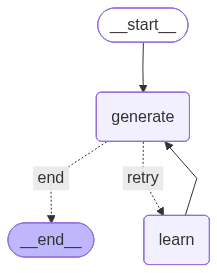

In [17]:
display(Image(reflexion_agent.get_graph().draw_mermaid_png()))

In [18]:
def solve_with_reflexion(
    task: str,
    user_id: str = "default",
    max_attempts: int = 3
) -> dict:
    """
    Solve task using reflexion (learns from past tasks in this session).
    
    Args:
        task: The problem to solve
        user_id: User identifier (lessons are per-user)
        max_attempts: Maximum retry attempts
    
    Returns:
        dict with solution and learning history
    """
    
    config = {
        "configurable": {
            "thread_id": f"reflexion-{user_id}"
        }
    }
    
    initial_state = {
        "messages": [HumanMessage(content=task)],
        "task": task,
        "solution": "",
        "feedback": "",
        "lessons_learned": [],
        "attempt_count": 0,
        "max_attempts": max_attempts,
        "success": False
    }
    
    try:
        result = reflexion_agent.invoke(initial_state, config=config)
        
        return {
            "success": result["success"],
            "solution": result["solution"],
            "feedback": result["feedback"],
            "attempts": result["attempt_count"],
            "lessons_learned": result["lessons_learned"],
            "total_lessons": len(result["lessons_learned"])
        }
    
    except Exception as e:
        logger.error(f"Reflexion failed: {e}")
        return {
            "success": False,
            "error": str(e)
        }

In [19]:
user_id = "developer-123"
    
tasks = [
    "Write a Python function to reverse a string efficiently",
    "Write a Python function to find duplicates in a list efficiently",
    "Write a Python function to merge two sorted lists efficiently"
]

print("\n" + "="*60)
print("REFLEXION DEMO: Learning Across Tasks")
print("="*60)

for i, task in enumerate(tasks, 1):
    print(f"\n--- TASK {i} ---")
    print(f"Task: {task}")
    
    result = solve_with_reflexion(task, user_id=user_id)
    
    if result["success"]:
        print(f"✅ Success on attempt {result['attempts']}")
        print(f"Solution: {result['solution'][:100]}...")
    else:
        print(f"❌ Failed after {result['attempts']} attempts")
        print(f"Feedback: {result['feedback']}")
    
    print(f"Lessons learned this task: {len(result['lessons_learned'])}")
    print(f"Total lessons accumulated: {result['total_lessons']}")

# Show all lessons learned
print(f"\n{'='*60}")
print("ALL LESSONS LEARNED:")
print(f"{'='*60}")

# Get final state to see all lessons
final_result = solve_with_reflexion(
    "Test task to retrieve lessons",
    user_id=user_id,
    max_attempts=1
)

for i, lesson in enumerate(final_result["lessons_learned"], 1):
    print(f"{i}. {lesson}")

INFO:__main__:Generating solution (attempt 1)



REFLEXION DEMO: Learning Across Tasks

--- TASK 1 ---
Task: Write a Python function to reverse a string efficiently


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:Retrying with new lesson
INFO:__main__:Analyzing failure to extract lesson
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:Learned: When implementing an efficient algorithm, consider the trade-offs between time complexity and space complexity, and choose the approach that best balances these factors.
INFO:__main__:Generating solution (attempt 2)
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:Retrying with new lesson
INFO:__main__:Analyzing failure to extract lesson
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:Learned: Always analyze and consider time and space complexity when implementing algorithms to optimize performance, especially for large inputs.
INFO:__main__:Generating solution (attempt 3)
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/

❌ Failed after 3 attempts
Feedback: Solution doesn't mention efficiency considerations
Lessons learned this task: 2
Total lessons accumulated: 2

--- TASK 2 ---
Task: Write a Python function to find duplicates in a list efficiently


INFO:__main__:Generating solution (attempt 5)
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


❌ Failed after 4 attempts
Feedback: Solution doesn't mention efficiency considerations
Lessons learned this task: 2
Total lessons accumulated: 2

--- TASK 3 ---
Task: Write a Python function to merge two sorted lists efficiently


INFO:__main__:Generating solution (attempt 6)
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


❌ Failed after 5 attempts
Feedback: Solution doesn't mention efficiency considerations
Lessons learned this task: 2
Total lessons accumulated: 2

ALL LESSONS LEARNED:


INFO:__main__:Solution successful!


1. When implementing an efficient algorithm, consider the trade-offs between time complexity and space complexity, and choose the approach that best balances these factors.
2. Always analyze and consider time and space complexity when implementing algorithms to optimize performance, especially for large inputs.


In [22]:
result["solution"]

'**Merging Two Sorted Lists Efficiently**\n=====================================\n\nHere is an efficient Python function to merge two sorted lists. This implementation has a time complexity of O(n + m) and a space complexity of O(n + m), where n and m are the lengths of the input lists.\n\n```python\ndef merge_sorted_lists(list1, list2):\n    """\n    Merge two sorted lists into one sorted list efficiently.\n\n    Args:\n        list1 (list): The first sorted list.\n        list2 (list): The second sorted list.\n\n    Returns:\n        list: A new sorted list containing all elements from both input lists.\n    """\n\n    # Initialize the result list\n    merged_list = []\n\n    # Initialize pointers for both input lists\n    i, j = 0, 0\n\n    # Merge smaller elements first\n    while i < len(list1) and j < len(list2):\n        if list1[i] < list2[j]:\n            # Append the smaller element from list1\n            merged_list.append(list1[i])\n            # Move to the next element i